[Reference](https://medium.com/@nomannayeem/from-data-to-decisions-turning-customer-behavior-into-purchase-predictions-c34a0c6302c7)

In [1]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score

In [3]:
# Sample code to generate synthetic data for demonstration
# In a real project, you would load your actual customer data
np.random.seed(42)

# Create synthetic customer data
n_samples = 1000
age = np.random.normal(40, 15, n_samples)
time_spent_on_site = np.random.exponential(5, n_samples)
pages_visited = np.random.poisson(5, n_samples)
previous_purchases = np.random.poisson(2, n_samples)
cart_value = np.random.exponential(50, n_samples)
is_returning_customer = np.random.binomial(1, 0.3, n_samples)
days_since_last_visit = np.random.exponential(30, n_samples)

# Create purchase probability based on features
purchase_prob = (0.02
                 + 0.001 * (age - 40)
                 + 0.05 * time_spent_on_site
                 + 0.03 * pages_visited
                 + 0.1 * previous_purchases
                 + 0.001 * cart_value
                 + 0.2 * is_returning_customer
                 - 0.003 * days_since_last_visit)

# Ensure probabilities are between 0 and 1
purchase_prob = np.clip(purchase_prob, 0, 0.9)

# Generate target variable: purchased (1) or not (0)
purchased = np.random.binomial(1, purchase_prob)

# Create dataframe
customer_data = pd.DataFrame({
    'age': age,
    'time_spent_on_site': time_spent_on_site,
    'pages_visited': pages_visited,
    'previous_purchases': previous_purchases,
    'cart_value': cart_value,
    'is_returning_customer': is_returning_customer,
    'days_since_last_visit': days_since_last_visit,
    'purchased': purchased
})

# Display the first few rows
print(customer_data.head())

         age  time_spent_on_site  pages_visited  previous_purchases  \
0  47.450712            0.916506              2                   2   
1  37.926035            0.552244              7                   2   
2  49.715328            5.058921              5                   3   
3  62.845448            6.128975              5                   4   
4  36.487699            0.160479              8                   2   

   cart_value  is_returning_customer  days_since_last_visit  purchased  
0   23.647242                      0              12.778776          1  
1  113.071609                      0               1.117658          1  
2   16.054145                      1               6.189104          1  
3   15.947042                      1              41.203766          1  
4   18.021405                      0              11.812129          1  


# Data Preparation and Exploration

               age  time_spent_on_site  pages_visited  previous_purchases  \
count  1000.000000         1000.000000    1000.000000         1000.000000   
mean     40.289981            5.039930       4.929000            2.032000   
std      14.688239            5.014943       2.096749            1.408886   
min      -8.619010            0.016117       0.000000            0.000000   
25%      30.286145            1.419773       3.000000            1.000000   
50%      40.379509            3.629656       5.000000            2.000000   
75%      49.719158            6.858421       6.000000            3.000000   
max      97.790972           37.208615      12.000000            8.000000   

        cart_value  is_returning_customer  days_since_last_visit    purchased  
count  1000.000000            1000.000000            1000.000000  1000.000000  
mean     51.290432               0.289000              29.897319     0.617000  
std      53.438651               0.453525              29.829538  

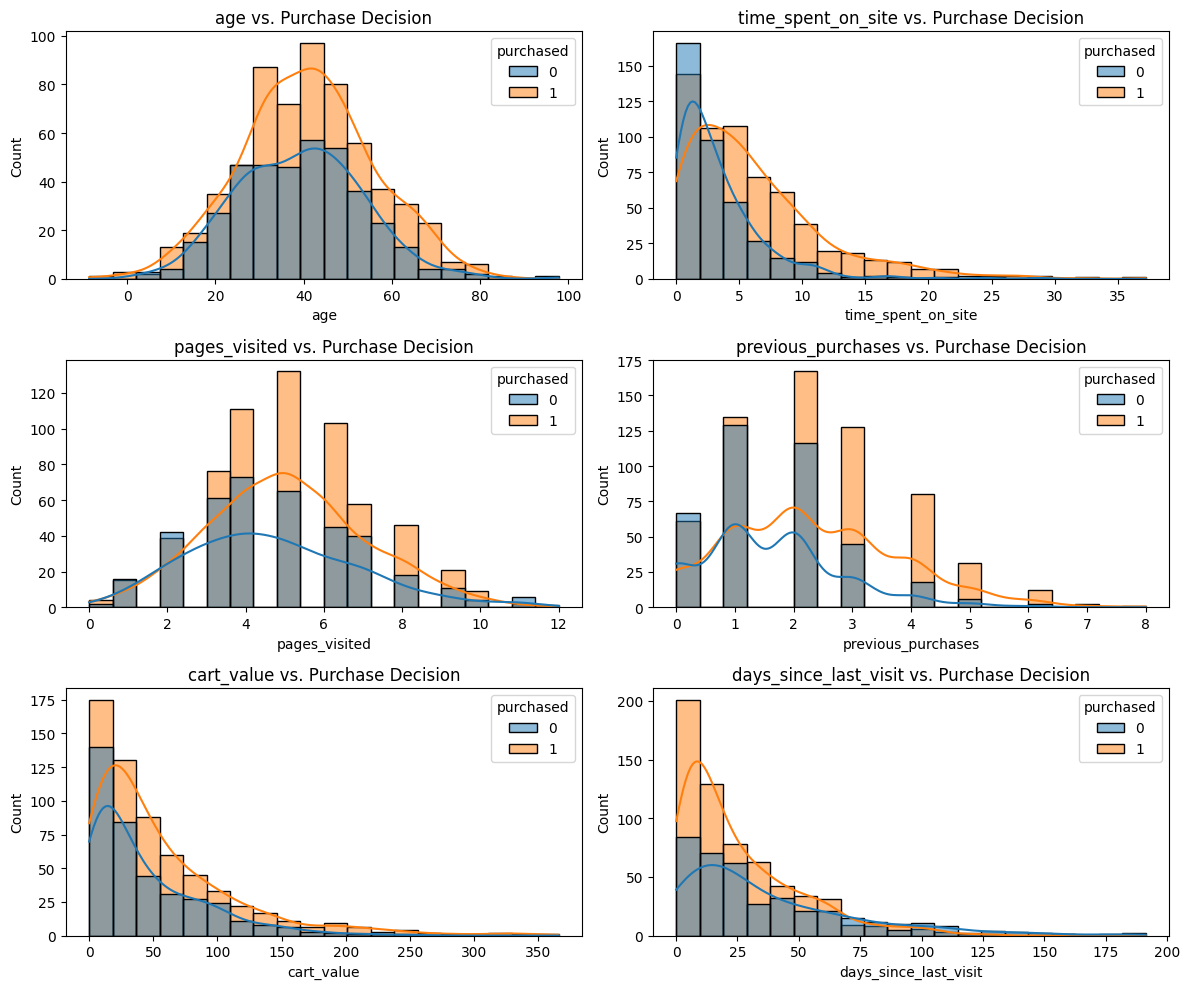

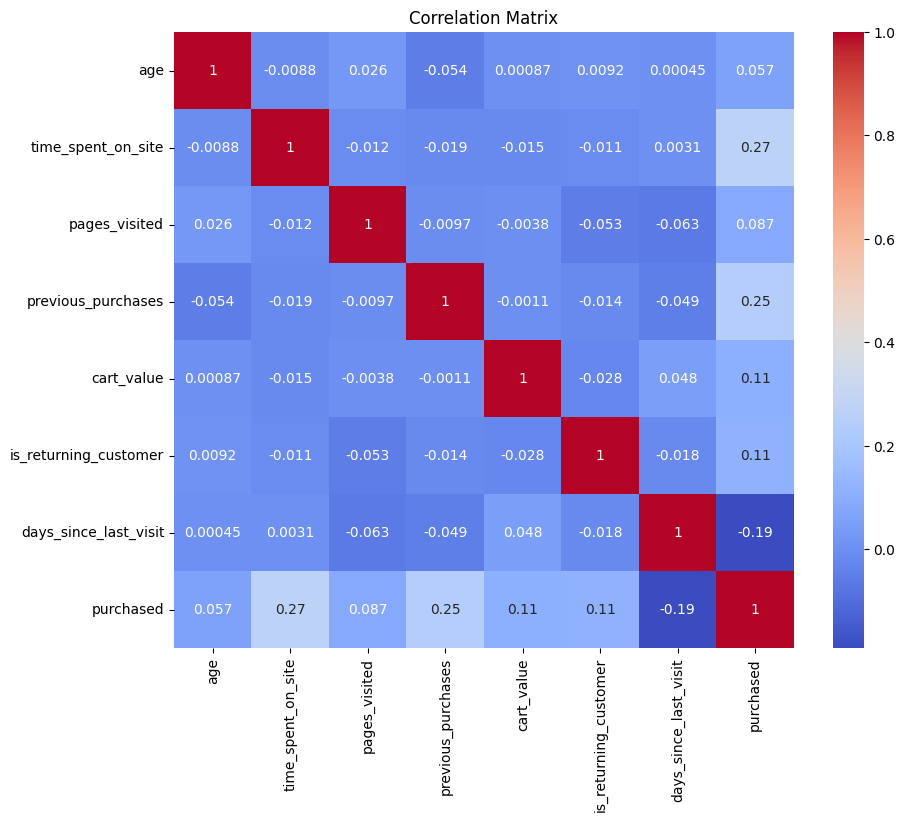

In [4]:
# Basic statistics
print(customer_data.describe())

# Check for missing values
print("Missing values:", customer_data.isnull().sum())

# Distribution of target variable
print("Purchase distribution:")
print(customer_data['purchased'].value_counts(normalize=True))

# Visualize relationships
plt.figure(figsize=(12, 10))

# Distribution of numerical features by purchase decision
features = ['age', 'time_spent_on_site', 'pages_visited', 'previous_purchases',
            'cart_value', 'days_since_last_visit']

for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=customer_data, x=feature, hue='purchased', bins=20, kde=True)
    plt.title(f'{feature} vs. Purchase Decision')
    plt.tight_layout()

plt.figure(figsize=(10, 8))
correlation = customer_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Engineering: Transforming Raw Data into Predictive Signals

In [5]:
# Feature engineering
customer_data['recency_score'] = 1 / (1 + customer_data['days_since_last_visit'])
customer_data['engagement_score'] = (customer_data['time_spent_on_site'] *
                                    customer_data['pages_visited']) / 10

# Create feature matrix X and target variable y
X = customer_data.drop('purchased', axis=1)
y = customer_data['purchased']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 800 samples
Test set: 200 samples


# Building the Model Pipeline

In [6]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', LogisticRegression(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Extract the logistic regression model
model = pipeline.named_steps['classifier']

# Get feature coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})

# Sort by absolute coefficient value
coefficients = coefficients.reindex(
    coefficients['Coefficient'].abs().sort_values(ascending=False).index
)

print("Feature Importance:")
print(coefficients)

Feature Importance:
                 Feature  Coefficient
1     time_spent_on_site     1.319198
3     previous_purchases     0.706864
6  days_since_last_visit    -0.510824
8       engagement_score    -0.382294
5  is_returning_customer     0.358938
4             cart_value     0.311523
2          pages_visited     0.311483
0                    age     0.149158
7          recency_score    -0.085743


# Model Evaluation: Measuring Prediction Performance

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        77
           1       0.73      0.82      0.77       123

    accuracy                           0.70       200
   macro avg       0.69      0.67      0.67       200
weighted avg       0.70      0.70      0.70       200



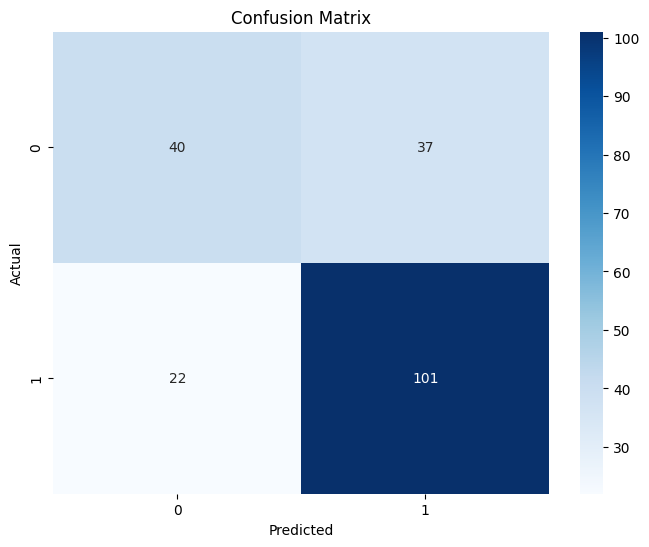

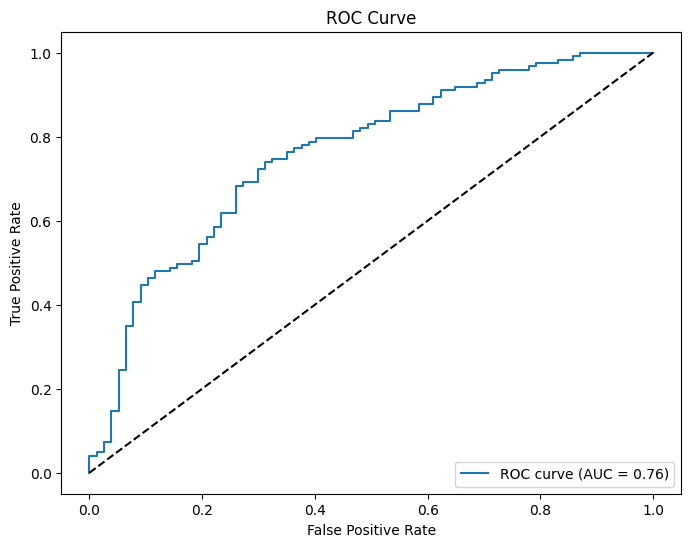

Cross-validation accuracy: 0.72 (+/- 0.02)


In [7]:
# Predictions
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

# Interpreting the Model: From Coefficients to Business Insights

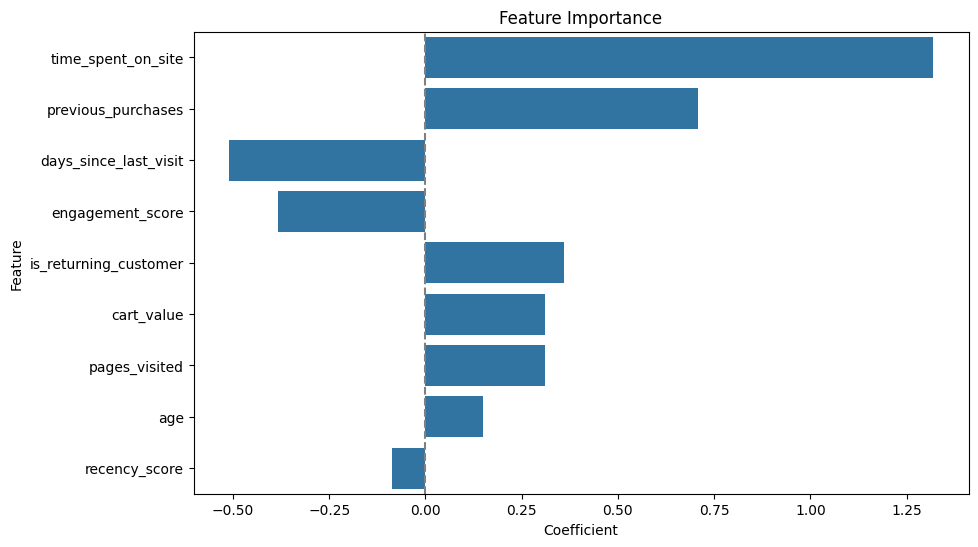

Odds Ratios (impact on purchase probability):
                 Feature  Odds Ratio  Coefficient
1     time_spent_on_site    3.740420     1.319198
3     previous_purchases    2.027622     0.706864
5  is_returning_customer    1.431808     0.358938
4             cart_value    1.365503     0.311523
2          pages_visited    1.365448     0.311483
0                    age    1.160856     0.149158
7          recency_score    0.917830    -0.085743
8       engagement_score    0.682295    -0.382294
6  days_since_last_visit    0.600001    -0.510824


In [8]:
# Feature importance visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.axvline(x=0, color='gray', linestyle='--')
plt.show()

# Calculate odds ratios for better interpretation
odds_ratios = pd.DataFrame({
    'Feature': X_train.columns,
    'Odds Ratio': np.exp(model.coef_[0]),
    'Coefficient': model.coef_[0]
})

print("Odds Ratios (impact on purchase probability):")
print(odds_ratios.sort_values('Odds Ratio', ascending=False))

# Making Predictions on New Customers

In [9]:
# Function to predict purchase probability for new customers
def predict_purchase_probability(new_customer_data, pipeline):
    """
    Predict the probability of purchase for new customers.

    Parameters:
    new_customer_data (DataFrame): Customer features
    pipeline: Trained model pipeline

    Returns:
    DataFrame: Original data with purchase probabilities
    """
    # Make a copy to avoid modifying the original
    df = new_customer_data.copy()

    # Add engineered features if they're not already present
    if 'recency_score' not in df.columns:
        df['recency_score'] = 1 / (1 + df['days_since_last_visit'])
    if 'engagement_score' not in df.columns:
        df['engagement_score'] = (df['time_spent_on_site'] * df['pages_visited']) / 10

    # Get predictions
    purchase_prob = pipeline.predict_proba(df)[:, 1]

    # Add predictions to the dataframe
    df['purchase_probability'] = purchase_prob
    df['likely_to_purchase'] = purchase_prob >= 0.5

    return df

# Example of using the function with new customer data
new_customers = pd.DataFrame({
    'age': [25, 45, 65],
    'time_spent_on_site': [2, 8, 1],
    'pages_visited': [3, 12, 2],
    'previous_purchases': [0, 5, 1],
    'cart_value': [20, 150, 30],
    'is_returning_customer': [0, 1, 1],
    'days_since_last_visit': [0, 5, 60]
})

# Generate predictions
predictions = predict_purchase_probability(new_customers, pipeline)
print("Purchase Predictions:")
print(predictions[['age', 'previous_purchases', 'purchase_probability', 'likely_to_purchase']])

Purchase Predictions:
   age  previous_purchases  purchase_probability  likely_to_purchase
0   25                   0              0.150679               False
1   45                   5              0.989627                True
2   65                   1              0.318226               False


# Saving the Model for Deployment

In [10]:
import joblib
joblib.dump(pipeline, 'purchase_prediction_model.pkl')

['purchase_prediction_model.pkl']

# Deploying with FastAPI: Creating a Dual-Interface Application

In [11]:
# app/models/prediction.py
from pydantic import BaseModel, Field

class CustomerData(BaseModel):
    """Model for customer data input"""
    age: float
    time_spent_on_site: float
    pages_visited: int
    previous_purchases: int
    cart_value: float
    is_returning_customer: int = Field(..., ge=0, le=1)
    days_since_last_visit: float

class PredictionResponse(BaseModel):
    """Model for prediction response"""
    purchase_probability: float
    likely_to_purchase: bool

In [12]:
# app/services/predictor.py
import joblib
import pandas as pd
# from app.models.prediction import CustomerData, PredictionResponse

class PredictorService:
    """Service for making predictions with the model"""

    def __init__(self, model_path: str):
        """Initialize with model path"""
        self.model = joblib.load(model_path)

    def predict(self, data: CustomerData) -> PredictionResponse:
        """Make prediction for a single customer"""
        # Convert to DataFrame for prediction
        df = pd.DataFrame([data.dict()])

        # Add engineered features (same as in training)
        df['recency_score'] = 1 / (1 + df['days_since_last_visit'])
        df['engagement_score'] = (df['time_spent_on_site'] * df['pages_visited']) / 10

        # Make prediction
        probability = self.model.predict_proba(df)[0][1]
        is_likely = probability >= 0.5

        return PredictionResponse(
            purchase_probability=float(probability),
            likely_to_purchase=bool(is_likely)
        )

In [15]:
# app/main.py
import os
from fastapi import FastAPI, Request, Form
from fastapi.templating import Jinja2Templates
from fastapi.staticfiles import StaticFiles
from fastapi.responses import HTMLResponse

# from app.models.prediction import CustomerData, PredictionResponse
# from app.services.predictor import PredictorService

# Get the directory of this file (app directory)
app_dir = os.path.dirname(os.path.abspath(__file__))

# Initialize FastAPI app
app = FastAPI(title="Purchase Prediction API")

# Mount static files directory (using absolute path)
static_dir = os.path.join(app_dir, "static")
app.mount("/static", StaticFiles(directory=static_dir), name="static")

# Set up templates directory (using absolute path)
templates_dir = os.path.join(app_dir, "templates")
templates = Jinja2Templates(directory=templates_dir)

# Construct the absolute path for the model file
# Assumes your project structure is:
#   Project_Root/
#     app/
#       main.py
#     downloaded_model/
base_dir = os.path.dirname(app_dir)
model_path = os.path.join(base_dir, "downloaded_model", "purchase_prediction_model.pkl")

# Initialize predictor service with the absolute model path
predictor_service = PredictorService(model_path)

@app.get("/", response_class=HTMLResponse)
async def root(request: Request):
    """Home page"""
    return templates.TemplateResponse("base.html", {"request": request})

@app.post("/predict")
async def predict(data: CustomerData):
    """API endpoint for prediction"""
    return predictor_service.predict(data)

@app.get("/predict-view", response_class=HTMLResponse)
async def predict_form(request: Request):
    """Web form for prediction"""
    return templates.TemplateResponse("prediction_form.html", {"request": request})

@app.post("/predict-view", response_class=HTMLResponse)
async def predict_form_submit(
    request: Request,
    age: float = Form(...),
    time_spent_on_site: float = Form(...),
    pages_visited: int = Form(...),
    previous_purchases: int = Form(...),
    cart_value: float = Form(...),
    is_returning_customer: int = Form(...),
    days_since_last_visit: float = Form(...)
):
    """Handle form submission and display result"""
    # Create CustomerData from form inputs
    data = CustomerData(
        age=age,
        time_spent_on_site=time_spent_on_site,
        pages_visited=pages_visited,
        previous_purchases=previous_purchases,
        cart_value=cart_value,
        is_returning_customer=is_returning_customer,
        days_since_last_visit=days_since_last_visit
    )

    # Make prediction
    result = predictor_service.predict(data)

    # Return form with result
    return templates.TemplateResponse(
        "prediction_form.html",
        {
            "request": request,
            "result": result,
            "form_data": data.dict()
        }
    )